In [137]:
import os
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import re

In [29]:
TRAIN_DIR = "../data/train"
VAL_DIR = "../data/val"
TRAIN_JSON = os.path.join(TRAIN_DIR, "train.json")
VAL_JSON = os.path.join(VAL_DIR, "val.json")

In [5]:
coco_train = COCO(TRAIN_JSON)
coco_val = COCO(VAL_JSON)

loading annotations into memory...
Done (t=0.85s)
creating index...
index created!
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


In [77]:
img_ids = coco_train.getImgIds()
print(f"Total images (train dataset): {len(img_ids)}")

Total images (train dataset): 3784


In [78]:
val_img_ids = coco_val.getImgIds()
print(f"Total images (val dataset): {len(val_img_ids)}")

Total images (val dataset): 933


In [69]:
img_id = img_ids[0]
img_info = coco_train.loadImgs([img_id])[0]
print(f"Image info: {img_info}")

Image info: {'height': 512, 'width': 512, 'id': 1, 'file_name': 'image/urban_0183_1_0.jpg'}


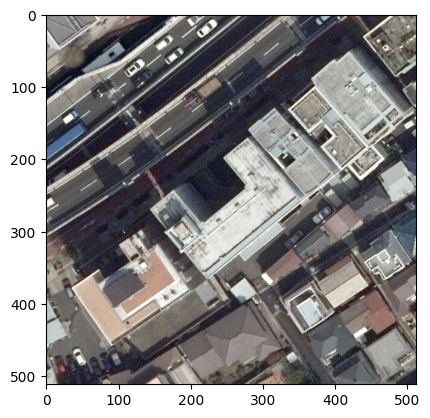

In [70]:
file_name = img_info['file_name']
img_path = os.path.normpath(os.path.join(TRAIN_DIR, file_name))
image = cv2.imread(img_path, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [80]:
cat_ids = coco_train.getCatIds()
print(f"Category names: {[cat['name'] for cat in coco_train.loadCats(cat_ids)]}")

Category names: ['building']


In [73]:
anns_ids = coco_train.getAnnIds(imgIds=[img_id], catIds=cat_ids, iscrowd=None)
anns = coco_train.loadAnns(anns_ids)
pprint(f"Example of annotation (one building of {img_info['file_name']}): {anns[0]}")


('Example of annotation (one building of image/urban_0183_1_0.jpg): '
 "{'iscrowd': 0, 'image_id': 1, 'bbox': [390, 466, 73, 46], 'segmentation': "
 "[[435, 465, 463, 506, 456, 511, 402, 511, 390, 494]], 'category_id': 0, "
 "'id': 1, 'area': 2016}")


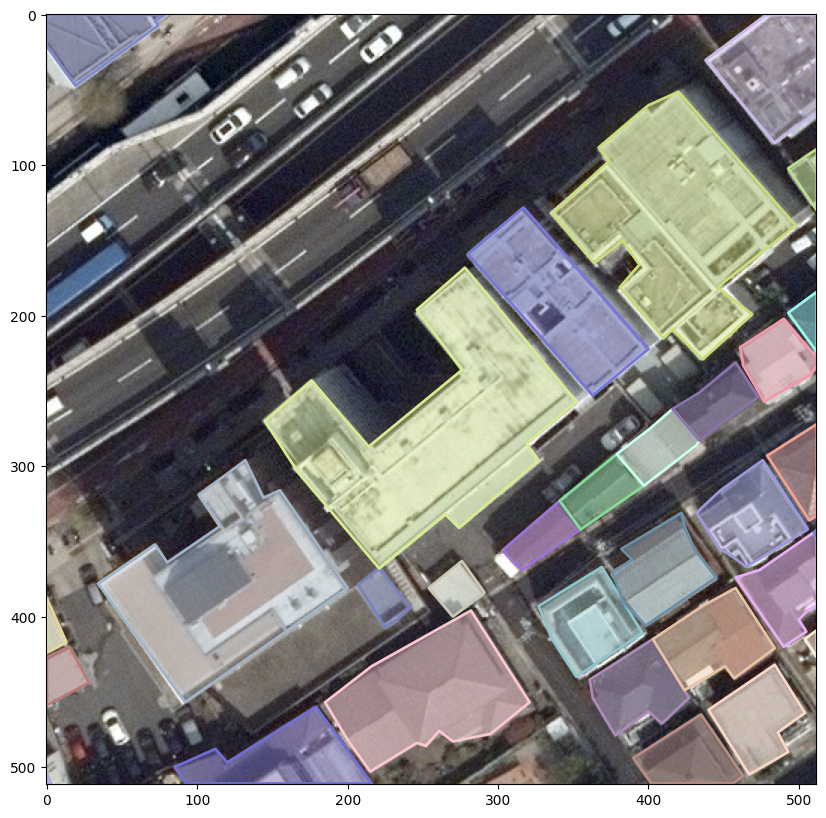

In [76]:
plt.figure(figsize=(10,10))
plt.imshow(image)
coco_train.showAnns(anns, draw_bbox=False)
plt.show()

In [84]:
def coco_to_dataframe(coco, split_name):
    rows = []
    for img_id in tqdm(coco.getImgIds(), desc=f"Processing {split_name}"):
        img_info = coco.loadImgs([img_id])[0]
        anns = coco.loadAnns(coco.getAnnIds(imgIds=[img_id], iscrowd=None))
        n = len(anns)
        if n == 0:
            rows.append({
                "split": split_name,
                "image_id": img_id,
                "file_name": img_info["file_name"],
                "width": img_info["width"],
                "height": img_info["height"],
                "n_buildings": 0,
                "mean_area": 0,
                "mean_bbox_w": 0,
                "mean_bbox_h": 0
            })
            continue

        areas = [a["area"] for a in anns]
        ws = [a["bbox"][2] for a in anns]
        hs = [a["bbox"][3] for a in anns]
        rows.append({
            "split": split_name,
            "image_id": img_id,
            "file_name": img_info["file_name"],
            "width": img_info["width"],
            "height": img_info["height"],
            "n_buildings": n,
            "mean_area": np.mean(areas),
            "mean_bbox_w": np.mean(ws),
            "mean_bbox_h": np.mean(hs)
        })
    return pd.DataFrame(rows)

df_train = coco_to_dataframe(coco_train, "train")
df_val   = coco_to_dataframe(coco_val, "val")

df_all = pd.concat([df_train, df_val], ignore_index=True)
df_all.head()


Processing val: 100%|██████████| 933/933 [00:00<00:00, 12880.87it/s]


,split,image_id,file_name,width,height,n_buildings,mean_area,mean_bbox_w,mean_bbox_h
0,train,1,image/urban_0183_1_0.jpg,512,512,31,3185.645161,67.516129,67.064516
1,train,2,image/rural_0222_1_0.jpg,512,512,18,1012.222222,38.722222,32.444444
2,train,3,image/suburban_0177_1_0.jpg,512,512,80,1424.375000,47.712500,45.650000
3,train,4,image/suburban_0307_0_1.jpg,512,512,15,1691.733333,49.533333,41.133333
4,train,5,image/CBD_0052_1_1.jpg,500,500,45,1873.222222,42.866667,42.466667


In [ ]:
print("Summary:")
display(df_all.describe())

Summary:


,image_id,width,height,n_buildings,mean_area,mean_bbox_w,mean_bbox_h
count,4717.000000,4717.000000,4717.000000,4717.000000,4717.000000,4717.000000,4717.000000
mean,1610.542930,509.483994,509.483994,39.579394,3658.855984,59.039219,58.054200
std,1137.655658,4.885371,4.885371,33.941774,10045.518742,40.212131,40.026421
min,1.000000,500.000000,500.000000,1.000000,0.000000,1.000000,2.000000
25%,590.000000,512.000000,512.000000,12.000000,1102.129032,39.614679,39.000000
50%,1426.000000,512.000000,512.000000,32.000000,1650.506173,48.270270,47.666667
75%,2605.000000,512.000000,512.000000,57.000000,3022.478261,63.707317,62.857143
max,3784.000000,512.000000,512.000000,224.000000,255262.000000,512.000000,512.000000


In [88]:
print("Distribution of number of buildings per image:")
display(df_all["n_buildings"].describe())

Distribution of number of buildings per image:


count    4717.000000
mean       39.579394
std        33.941774
min         1.000000
25%        12.000000
50%        32.000000
75%        57.000000
max       224.000000
Name: n_buildings, dtype: float64

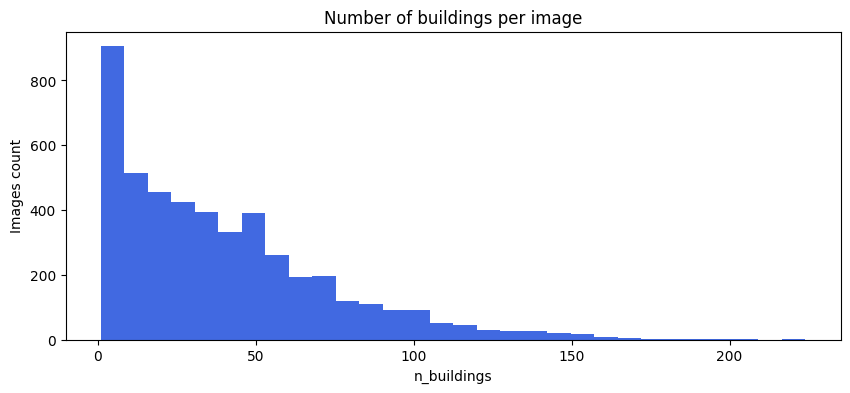

In [92]:
plt.figure(figsize=(10,4))
plt.hist(df_all["n_buildings"], bins=30, color="royalblue")
plt.title("Number of buildings per image")
plt.xlabel("n_buildings")
plt.ylabel("Images count")
plt.show()

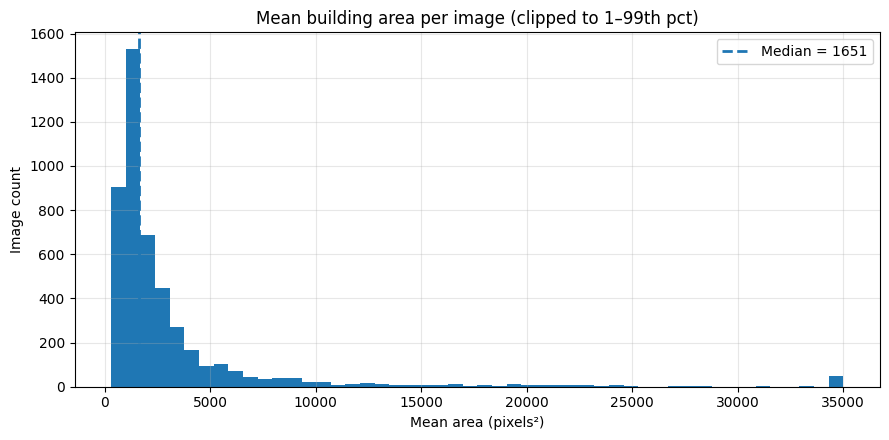

In [ ]:
p1, p50, p99 = np.percentile(df_all["mean_area"], [1, 50, 99])
x = np.clip(df_all["mean_area"].values, p1, p99)
plt.figure(figsize=(9,4.5))
plt.hist(x, bins=50)
plt.axvline(p50, ls="--", lw=2, label=f"Median = {p50:.0f}")
plt.title("Mean building area per image (clipped to 1–99th pct)")
plt.xlabel("Mean area (pixels²)")
plt.ylabel("Image count")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


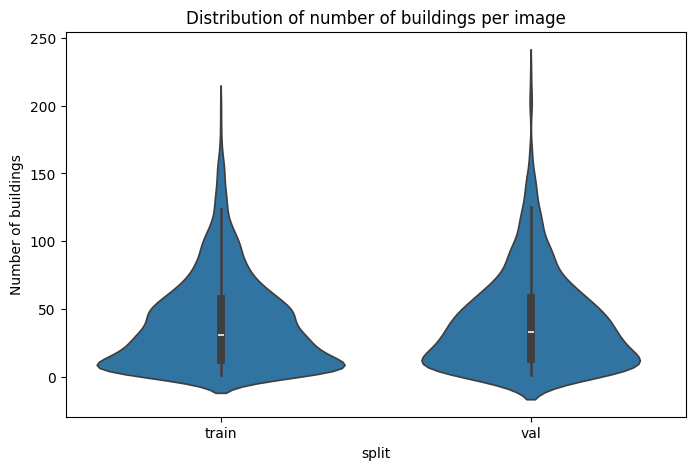

In [113]:
plt.figure(figsize=(8,5))
sns.violinplot(data=df_all, x="split", y="n_buildings", inner="box")
plt.title("Distribution of number of buildings per image")
plt.ylabel("Number of buildings")
plt.show()

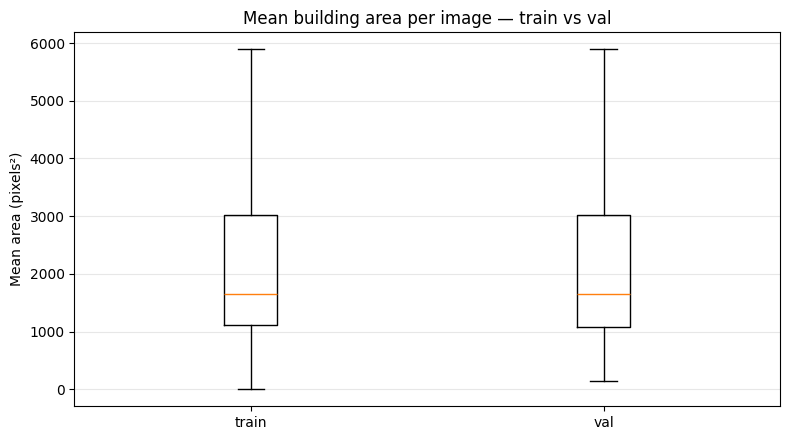

In [116]:
plt.figure(figsize=(8,4.5))
data = [df_all.loc[df_all["split"]=="train","mean_area"],
        df_all.loc[df_all["split"]=="val","mean_area"]]
plt.boxplot(data, tick_labels=["train","val"], showfliers=False)
plt.title("Mean building area per image — train vs val")
plt.ylabel("Mean area (pixels²)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [119]:
print("Top 5 images with MOST buildings:")
display(df_all.sort_values("n_buildings", ascending=False).head())

print("Top 5 images with FEWEST buildings:")
display(df_all.sort_values("n_buildings", ascending=True).head())


Top 5 images with MOST buildings:


,split,image_id,file_name,width,height,n_buildings,mean_area,mean_bbox_w,mean_bbox_h
3867,val,84,image/CBD_0084_0_0.jpg,500,500,224,640.687500,27.062500,29.928571
3986,val,203,image/urban_0124_1_1.jpg,512,512,207,810.367150,37.338164,38.951691
4259,val,476,image/urban_0118_0_1.jpg,512,512,202,770.138614,32.900990,39.816832
184,train,185,image/urban_0130_1_0.jpg,512,512,202,750.693069,37.747525,37.693069
3787,val,4,image/CBD_0067_1_0.jpg,500,500,199,541.819095,22.170854,26.040201


Top 5 images with FEWEST buildings:


,split,image_id,file_name,width,height,n_buildings,mean_area,mean_bbox_w,mean_bbox_h
3923,val,140,image/rural_0035_0_0.jpg,512,512,1,20881.0,171.0,225.0
2949,train,2950,image/rural_0071_0_1.jpg,512,512,1,937.0,67.0,31.0
3377,train,3378,image/rural_0224_1_1.jpg,512,512,1,4964.0,101.0,59.0
563,train,564,image/rural_0180_1_1.jpg,512,512,1,248217.0,512.0,512.0
425,train,426,image/rural_0165_1_0.jpg,512,512,1,123.0,9.0,26.0


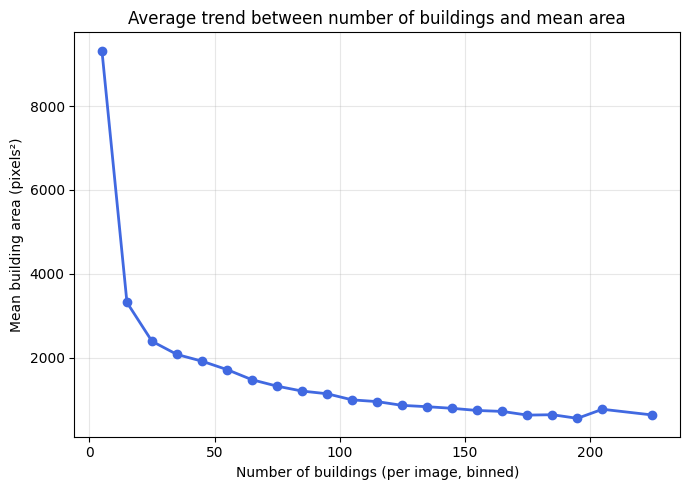

In [135]:
df_temp = df_all.copy()
df_temp["bin"] = pd.cut(df_temp["n_buildings"], bins=np.arange(0, 250, 10))
agg = df_temp.groupby("bin", observed=True)["mean_area"].mean().reset_index()
centers = [b.mid for b in agg["bin"]]
plt.figure(figsize=(7,5))
plt.plot(centers, agg["mean_area"], marker="o", lw=2, color="royalblue")
plt.xlabel("Number of buildings (per image, binned)")
plt.ylabel("Mean building area (pixels²)")
plt.title("Average trend between number of buildings and mean area")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [138]:
def extract_area_type(fname):
    m = re.match(r"([a-zA-Z]+)_", os.path.basename(fname))
    if m:
        return m.group(1).lower()
    return "unknown"

df_all["area_type"] = df_all["file_name"].apply(extract_area_type)
df_all["area_type"].value_counts()

area_type
suburban    1309
urban       1263
cbd         1097
rural       1048
Name: count, dtype: int64

In [140]:
grouped = df_all.groupby("area_type").agg({
    "image_id": "count",
    "n_buildings": ["mean", "max"],
    "mean_area": "mean",
    "mean_bbox_w": "mean",
    "mean_bbox_h": "mean"
}).reset_index()
grouped.columns = ["area_type", "n_images", "mean_n_buildings", "max_n_buildings", "mean_area", "mean_bbox_w", "mean_bbox_h"]
grouped.sort_values("n_images", ascending=False)


,area_type,n_images,mean_n_buildings,max_n_buildings,mean_area,mean_bbox_w,mean_bbox_h
2,suburban,1309,26.047364,135,5597.780884,72.391476,69.904590
3,urban,1263,50.178939,207,2989.193677,59.864139,58.838820
0,cbd,1097,63.578851,224,2599.404309,51.341354,52.401314
1,rural,1048,18.585878,91,3153.082403,49.425268,48.224122


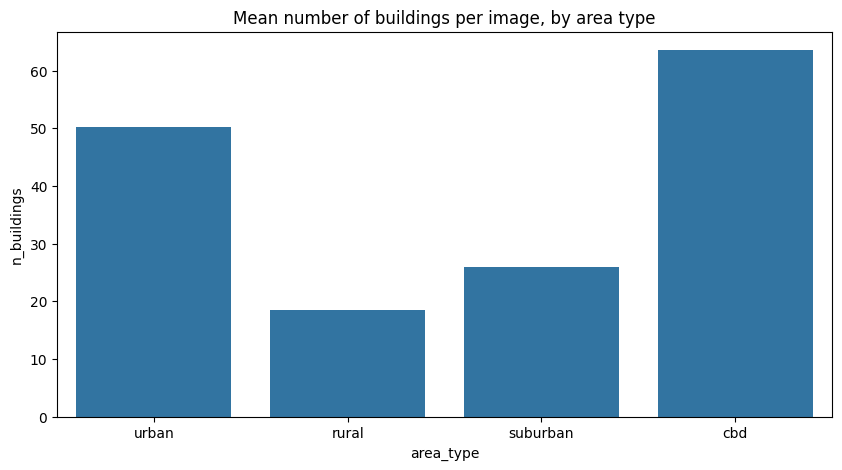

In [151]:
plt.figure(figsize=(10,5))
sns.barplot(data=df_all, x="area_type", y="n_buildings", errorbar=None)
plt.title("Mean number of buildings per image, by area type")
plt.show()


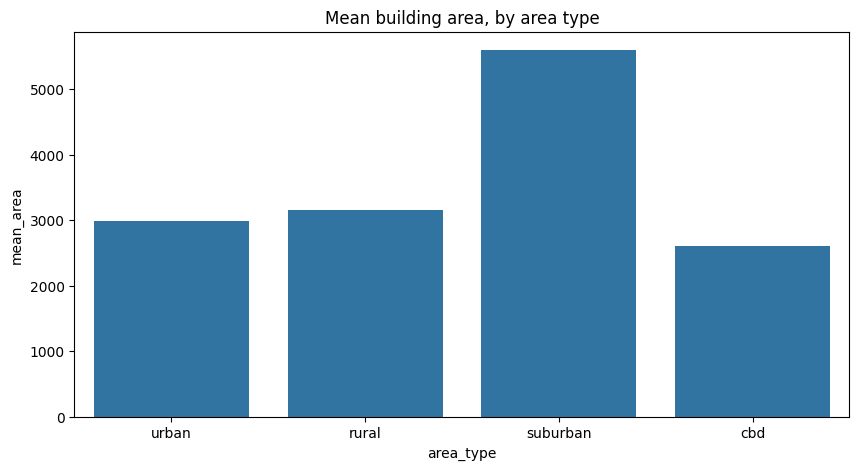

In [152]:
plt.figure(figsize=(10,5))
sns.barplot(data=df_all, x="area_type", y="mean_area", errorbar=None)
plt.title("Mean building area, by area type")
plt.show()


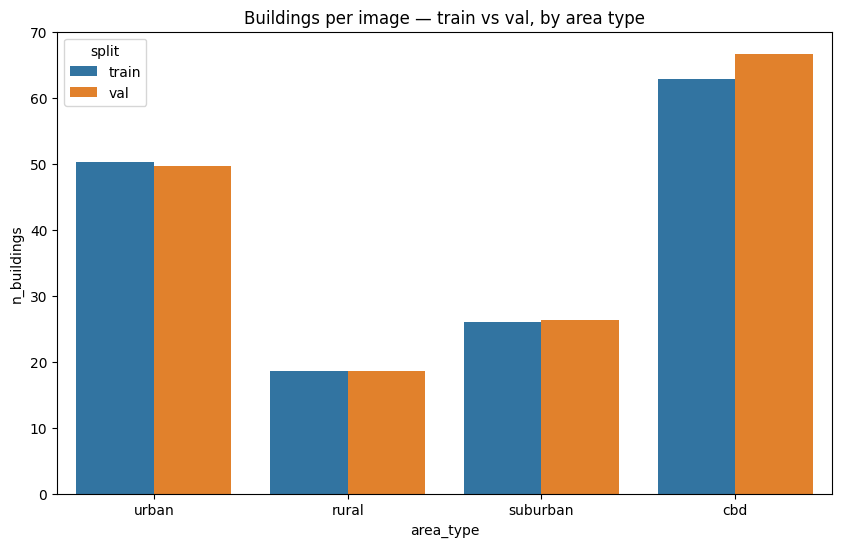

In [153]:
plt.figure(figsize=(10,6))
sns.barplot(data=df_all, x="area_type", y="n_buildings", hue="split", errorbar=None)
plt.title("Buildings per image — train vs val, by area type")
plt.show()

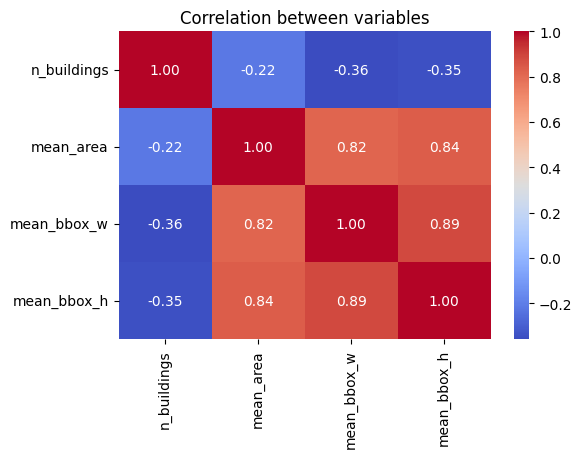

In [156]:
plt.figure(figsize=(6,4))
sns.heatmap(df_all[["n_buildings","mean_area","mean_bbox_w","mean_bbox_h"]].corr(),annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between variables")
plt.show()
